In [123]:
import json
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from pathlib import Path
import logging
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from torch.nn import CTCLoss
import regex as re
from torch.nn import functional as F
import time

In [124]:
txt_path = '/kaggle/input/vietnamese-scene-text-spotting-dataset-vintext/train_vintext_label.txt'
data_dir = '/kaggle/input/vietnamese-scene-text-spotting-dataset-vintext/vintext/vintext/train_images'

In [125]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

def extract_data_from_txt(txt_path, data_dir):
    """
    Trích xuất dữ liệu từ file train_vintext_label.txt.
    Args:
        txt_path (str): Đường dẫn đến file txt.
        data_dir (str): Đường dẫn đến thư mục chứa ảnh.
    Returns:
        img_paths (list): Danh sách đường dẫn ảnh.
        img_sizes (list): Danh sách kích thước ảnh (width, height).
        img_labels (list): Danh sách nhãn.
        bboxes (list): Danh sách hộp giới hạn.
    """
    img_paths = []
    img_sizes = []
    img_labels = []
    bboxes = []

    # Kiểm tra sự tồn tại của file txt
    if not os.path.exists(txt_path):
        logging.error(f"File {txt_path} không tồn tại.")
        return img_paths, img_sizes, img_labels, bboxes

    with open(txt_path, 'r', encoding='utf-8') as f:
        for line in f:
            # Tách đường dẫn ảnh và dữ liệu JSON
            parts = line.strip().split('\t')
            if len(parts) != 2:
                logging.warning(f"Dòng không hợp lệ: {line.strip()}")
                continue
            img_path, json_data = parts

            # Tạo đường dẫn đầy đủ đến file ảnh
            full_img_path = os.path.join(data_dir, os.path.basename(img_path))
            
            # Kiểm tra sự tồn tại của file ảnh
            if not os.path.exists(full_img_path):
                logging.warning(f"Không tìm thấy file ảnh: {full_img_path}")
                continue

            # Đọc kích thước ảnh
            img = cv2.imread(full_img_path)
            if img is None:
                logging.warning(f"Không thể đọc file ảnh: {full_img_path}")
                continue
            height, width = img.shape[:2]

            # Phân tích dữ liệu JSON
            try:
                annotations = json.loads(json_data)
            except json.JSONDecodeError as e:
                logging.warning(f"Lỗi JSON tại dòng: {line.strip()}. Lỗi: {e}")
                continue

            for ann in annotations:
                transcription = ann['transcription']
                points = ann['points']

                # Loại bỏ các nhãn không hợp lệ (ví dụ: '###')
                if transcription == '###':
                    continue

                # Kiểm tra và làm sạch nhãn
                if not transcription.strip():
                    continue

                # Lấy tọa độ hộp giới hạn từ points
                x_min = min(p[0] for p in points)
                y_min = min(p[1] for p in points)
                x_max = max(p[0] for p in points)
                y_max = max(p[1] for p in points)

                # Thêm dữ liệu vào danh sách
                img_paths.append(full_img_path)
                img_sizes.append((width, height))
                img_labels.append(transcription.lower())
                bboxes.append([x_min, y_min, x_max, y_max])

    return img_paths, img_sizes, img_labels, bboxes

In [126]:
img_paths, img_sizes, img_labels, bboxes = extract_data_from_txt(txt_path, data_dir)

In [127]:
print(f"Total images: {len(img_paths)}")
print(f"Total bounding boxes: {sum([len(bbs) for bbs in bboxes])}")

Total images: 25776
Total bounding boxes: 103104


In [128]:
def plot_image_with_bbs(img_path, bboxes, labels):
    """
    Hiển thị ảnh với các hộp giới hạn và nhãn.
    Args:
        img_path (str): Đường dẫn đến ảnh.
        bboxes (list): Danh sách hộp giới hạn.
        labels (list): Danh sách nhãn.
    """
    # Đọc và chuyển đổi ảnh sang RGB
    img = cv2.imread(img_path)
    if img is None:
        logging.error(f"Không thể đọc ảnh để hiển thị: {img_path}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Vẽ hộp giới hạn và nhãn
    for bbox, label in zip(bboxes, labels):
        x_min, y_min, x_max, y_max = map(int, bbox)
        # Vẽ hộp giới hạn
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

        # Thêm nền cho nhãn
        (text_width, text_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
        cv2.rectangle(img, (x_min, y_min - text_height - 10), (x_min + text_width, y_min), (255, 0, 0), -1)

        # Thêm nhãn
        cv2.putText(img, label, (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    # Hiển thị ảnh
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

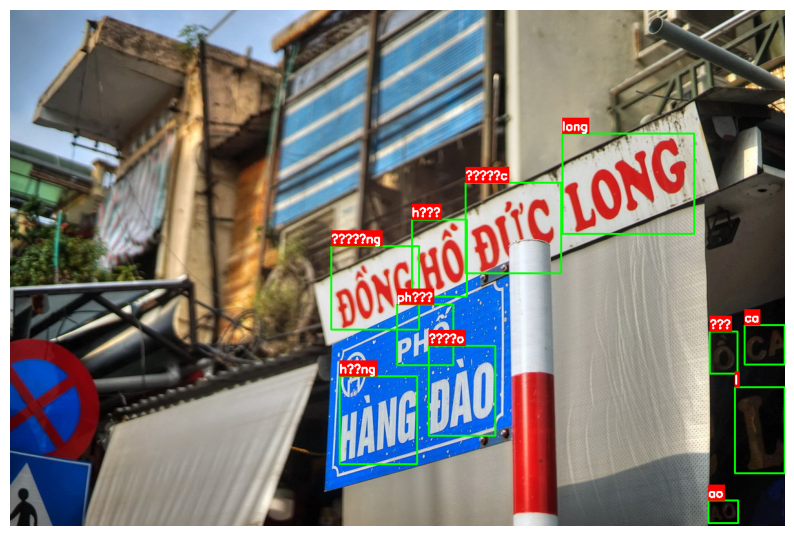

In [129]:
unique_images = list(set(img_paths))
if unique_images:
    selected_img = random.choice(unique_images)
    selected_bboxes = [bbox for i, bbox in enumerate(bboxes) if img_paths[i] == selected_img]
    selected_labels = [label for i, label in enumerate(img_labels) if img_paths[i] == selected_img]
    plot_image_with_bbs(selected_img, selected_bboxes, selected_labels)
else:
    logging.warning("Không có ảnh nào được tải để hiển thị.")

In [130]:
import os
import logging
import numpy as np
from PIL import Image
import regex as re  # Sử dụng regex để hỗ trợ \p{L}

def split_bounding_boxes(img_paths, img_labels, bboxes, save_dir):
    """
    Cắt các vùng văn bản từ ảnh dựa trên hộp giới hạn, lọc và lưu thành file ảnh.
    Tạo file labels.txt chứa đường dẫn ảnh và nhãn.
    Loại bỏ các nhãn chứa ký tự đặc biệt, giữ lại ký tự tiếng Việt có dấu, và xóa khoảng trắng.
    
    Args:
        img_paths (list): Danh sách đường dẫn ảnh.
        img_labels (list): Danh sách nhãn tương ứng với từng hộp giới hạn.
        bboxes (list): Danh sách hộp giới hạn [x_min, y_min, x_max, y_max].
        save_dir (str): Thư mục để lưu ảnh cắt và file labels.txt.
    
    Returns:
        None
    """
    # Thiết lập logging
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

    # Tạo thư mục lưu ảnh nếu chưa tồn tại
    os.makedirs(save_dir, exist_ok=True)

    count = 0
    labels = []  # Danh sách lưu đường dẫn ảnh và nhãn

    # Biểu thức chính quy để kiểm tra nhãn:
    # Cho phép chữ cái Unicode (bao gồm tiếng Việt), số, dấu gạch dưới; không cho phép khoảng trắng
    valid_label_pattern = re.compile(r'^[\p{L}0-9_]+$')

    # Duyệt qua từng ảnh, nhãn, và hộp giới hạn
    for img_path, label, bb in zip(img_paths, img_labels, bboxes):
        try:
            # Kiểm tra nhãn có phải chuỗi không
            if not isinstance(label, str):
                logging.warning(f"Bỏ qua nhãn không hợp lệ cho ảnh {img_path}: {label}")
                continue

            # Xóa tất cả khoảng trắng từ nhãn
            cleaned_label = re.sub(r'\s+', '', label)

            # Kiểm tra nhãn sau khi xóa khoảng trắng
            if not cleaned_label or not valid_label_pattern.match(cleaned_label):
                logging.warning(f"Bỏ qua nhãn không hợp lệ sau khi xóa khoảng trắng cho ảnh {img_path}: {cleaned_label}")
                continue

            # Mở ảnh
            img = Image.open(img_path).convert('RGB')
        except Exception as e:
            logging.warning(f"Không thể mở ảnh {img_path}: {e}")
            continue

        try:
            # Cắt vùng văn bản theo hộp giới hạn [x_min, y_min, x_max, y_max]
            x_min, y_min, x_max, y_max = map(int, bb)
            if x_min >= x_max or y_min >= y_max:
                logging.warning(f"Hộp giới hạn không hợp lệ cho ảnh {img_path}: {bb}")
                continue

            cropped_img = img.crop((x_min, y_min, x_max, y_max))

            # Chuyển sang numpy để kiểm tra màu
            cropped_array = np.array(cropped_img)

            # Lọc bỏ nếu 90% ảnh là đen (mean < 35) hoặc trắng (mean > 220)
            if np.mean(cropped_array) < 35 or np.mean(cropped_array) > 220:
                logging.info(f"Bỏ qua vùng cắt từ {img_path} do quá đen/trắng")
                continue

            # Lọc bỏ nếu kích thước quá nhỏ
            if cropped_img.size[0] < 10 or cropped_img.size[1] < 10:
                logging.info(f"Bỏ qua vùng cắt từ {img_path} do kích thước quá nhỏ")
                continue

            # Lưu ảnh cắt
            filename = f"{count:06d}.jpg"
            save_path = os.path.join(save_dir, filename)
            cropped_img.save(save_path)

            # Tạo dòng nhãn: đường dẫn ảnh + tab + nhãn (đã xóa khoảng trắng)
            label_line = f"{save_path}\t{cleaned_label}"
            labels.append(label_line)

            count += 1
            logging.info(f"Đã lưu ảnh cắt {save_path}")

        except Exception as e:
            logging.warning(f"Lỗi khi xử lý vùng cắt từ {img_path}: {e}")
            continue

    # In số lượng ảnh đã tạo
    print(f"Đã tạo {count} ảnh")

    # Lưu file labels.txt
    labels_file = os.path.join(save_dir, "labels.txt")
    try:
        with open(labels_file, "w", encoding='utf-8') as f:
            for label_line in labels:
                f.write(f"{label_line}\n")
        logging.info(f"Đã lưu file nhãn tại {labels_file}")
    except Exception as e:
        logging.error(f"Lỗi khi lưu file labels.txt: {e}")

In [131]:
save_dir = "datasets/ocr_dataset"
split_bounding_boxes(img_paths, img_labels, bboxes, save_dir)

Đã tạo 21179 ảnh


In [132]:
root_dir = save_dir

img_paths = []
labels = []

# Read labels from text file
with open(os.path.join(root_dir, "labels.txt"), "r") as f:
    for label in f:
        labels.append(label.strip().split("\t")[1])
        img_paths.append(label.strip().split("\t")[0])

print(f"Total images: {len(img_paths)}")


Total images: 21179


Total images: 21179


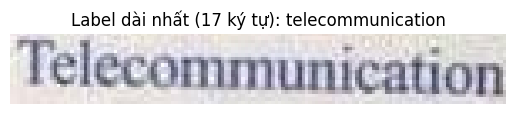

In [133]:
import os
from PIL import Image
import matplotlib.pyplot as plt

root_dir = save_dir

img_paths = []
labels = []

# Đọc file labels.txt và tách thành đường dẫn + nhãn
with open(os.path.join(root_dir, "labels.txt"), "r") as f:
    for line in f:
        parts = line.strip().split("\t")
        if len(parts) == 2:
            img_paths.append(parts[0])
            labels.append(parts[1])

print(f"Total images: {len(img_paths)}")

# Tìm label dài nhất và vị trí của nó
max_len = max(len(label) for label in labels)
max_index = [i for i, label in enumerate(labels) if len(label) == max_len][0]  # lấy cái đầu tiên

# Lấy ảnh và label tương ứng
longest_img_path = os.path.join(img_paths[max_index])
longest_label = labels[max_index]

# Hiển thị ảnh
img = Image.open(longest_img_path)

plt.imshow(img)
plt.title(f"Label dài nhất ({len(longest_label)} ký tự): {longest_label}")
plt.axis("off")
plt.show()


In [134]:
letters = [char.split(".")[0].lower() for char in labels]
letters = "".join(letters)
letters = sorted(list(set(list(letters))))

# create a string of all characters in the dataset
chars = "".join(letters)

# for "blank" character
blank_char = "-"
chars += blank_char
vocab_size = len(chars)

print(f"Vocab: {chars}")
print(f"Vocab size: {vocab_size}")

Vocab: 0123456789_abcdefghijklmnopqrstuvwxyzàáâãèéêìíòóôõùúýăđĩũơưạảấầẩẫậắằẳẵặẹẻẽếềểễệỉịọỏốồổỗộớờởỡợụủứừửữựỳỷỹ-
Vocab size: 104


In [135]:
char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

In [136]:
max_label_len = max([len(label) for label in labels])
max_label_len

17

In [153]:
longest_label = max(labels, key=lambda x: len(x))
print("Label dài nhất:", longest_label)
print("Độ dài:", len(longest_label))
seq_len = 21

Label dài nhất: telecommunication
Độ dài: 17


In [154]:
char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}


def encode(label, char_to_idx, seq_len):
    encoded_labels = torch.tensor(
        [char_to_idx[char] for char in label], dtype=torch.long
    )
    label_len = len(encoded_labels)
    lengths = torch.tensor(label_len, dtype=torch.long)
    padded_labels = F.pad(encoded_labels, (0, seq_len - label_len), value=0)

    return padded_labels, lengths

In [155]:
def decode(encoded_sequences, idx_to_char, blank_char="-"):
    decoded_sequences = []

    for seq in encoded_sequences:
        decoded_label = []
        prev_char = None  # To track the previous character

        for token in seq:
            if token != 0:  # Ignore padding (token = 0)
                char = idx_to_char[token.item()]
                # Append the character if it's not a blank or the same as the previous character
                if char != blank_char:
                    if char != prev_char or prev_char == blank_char:
                        decoded_label.append(char)
                prev_char = char  # Update previous character

        decoded_sequences.append("".join(decoded_label))
        
    # print(f"From {encoded_sequences} to {decoded_sequences}")

    return decoded_sequences

In [156]:
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize((100, 420)),
            transforms.ColorJitter(
                brightness=0.5,
                contrast=0.5,
                saturation=0.5,
            ),
            transforms.Grayscale(
                num_output_channels=1,
            ),
            transforms.GaussianBlur(3),
            transforms.RandomAffine(
                degrees=1,
                shear=1,
            ),
            transforms.RandomPerspective(
                distortion_scale=0.3,
                p=0.5,
                interpolation=3,
            ),
            transforms.RandomRotation(degrees=2),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize((100, 420)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
}

In [157]:
seed = 0
val_size = 0.1
test_size = 0.1
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths,
    labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle,
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle,
)

In [158]:
class STRDataset(Dataset):
    def __init__(
        self,
        X,
        y,
        char_to_idx,
        max_label_len,
        label_encoder=None,
        transform=None,
    ):
        self.transform = transform
        self.img_paths = X
        self.labels = y
        self.char_to_idx = char_to_idx
        self.max_label_len = max_label_len
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        if self.label_encoder:
            encoded_label, label_len = self.label_encoder(
                label, self.char_to_idx, self.max_label_len
            )
        return img, encoded_label, label_len

In [ ]:
train_dataset = STRDataset(
    X_train,
    y_train,
    char_to_idx=char_to_idx,    
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms["train"],
)
val_dataset = STRDataset(
    X_val,
    y_val,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms["val"],
)
test_dataset = STRDataset(
    X_test,
    y_test,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms["val"],
)

In [160]:
print(
    f"Train dataset: {len(train_dataset)}",
    f"Val dataset: {len(val_dataset)}",
    f"Test dataset: {len(test_dataset)}",
    sep="\n",
)

Train dataset: 17154
Val dataset: 2118
Test dataset: 1907


In [161]:
train_batch_size = 64
test_batch_size = 64 * 2

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False,
)

['quý', 'khai', '121', 'a0', 'cưới', 'cty', 'đang', 'cộng', 'đài', 'võ', '80m', 'tam', 'tự', 'cựu', 'nhưng', 'bắc', 'lai', 'gió', 'gas', 'hà', 'thả', 'lai', 'kệ', 'xây', 'hàng', 'thơ', 'kinh', 'ân', '17547461', 'vietnam', 'sư', 'khuyến', '042468710', 'minh', 'tầng', 'hội', 'cửa', 'văn', 'tâm', 'hàng', 'dâm', 'ra', 'chữa', 'xách', 'có', 'thế', 'nguồn', 'tri', 'rượu', 'minh', 'bí', 'dịch', 'minh', 'đầu', 'vị', 'phối', 'bring', 'alo', 'đình', 'đồng', 'ngừa', 'lớp', 'do', 'ngon']


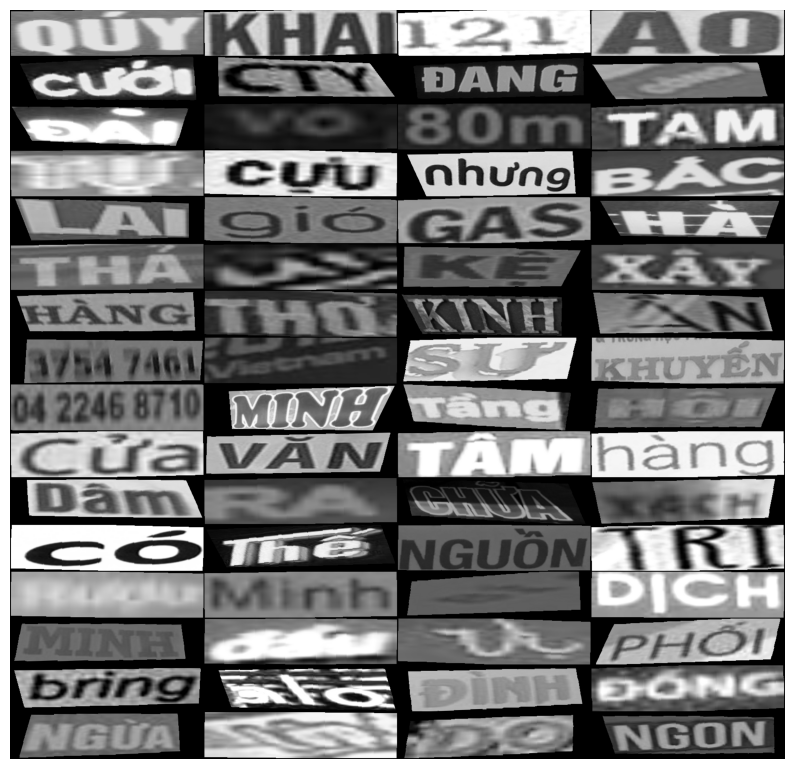

In [162]:
train_features, train_labels, train_lengths = next(iter(train_loader))


# use torchvision to display a grid of images
def show_batch(imgs, labels):
    labels = decode(labels, idx_to_char)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True)
    plt.figure(figsize=(10, 20))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis("off")
    print(labels)
    plt.show()


show_batch(train_features, train_labels)

In [163]:
import torch
import torch.nn as nn

class CRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers, dropout=0.2):
        super(CRNN, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Changed

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(5, 5),  # Changed

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),  # Changed

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))
        )

        self.mapSeq = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.gru = nn.GRU(
            512,
            hidden_size,
            n_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0
        )
        self.layer_norm = nn.LayerNorm(hidden_size * 2)

        self.out = nn.Sequential(
            nn.Linear(hidden_size * 2, vocab_size),
            nn.LogSoftmax(dim=2)
        )

    def forward(self, x):
        x = self.cnn(x)  # (B, C=512, H=1, W=14)
        x = x.squeeze(2)  # (B, 512, W=14)
        x = x.permute(0, 2, 1)  # (B, W=14, 512) —> seq_len = 14

        x = self.mapSeq(x)      # (B, 14, 512)
        x, _ = self.gru(x)      # (B, 14, hidden*2)
        x = self.layer_norm(x)
        x = self.out(x)         # (B, 14, vocab_size)
        x = x.permute(1, 0, 2)  # (14, B, vocab_size) —> CTC format
        return x

In [171]:
vocab_size = 105  # Assuming this is correct based on output
hidden_size = 256
n_layers = 3
dropout_prob = 0.3
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CRNN(
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout=dropout_prob,
).to(device)

In [172]:
model.eval()

dummy_tensor = torch.rand((64, 1, 100, 420)).to(device)

with torch.no_grad():
    output = model(dummy_tensor)

print("Output shape:", output.shape)

Output shape: torch.Size([21, 64, 105])


In [173]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for idx, (inputs, labels, labels_len) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            outputs = model(inputs)
            logits_lens = torch.full(
                size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long
            ).to(device)

            # Print some samples after decoding
            # if idx == 0:
            #     print(decode(outputs.permute(1, 0, 2).argmax(2), idx_to_char)[:10])
            #     print(decode(labels, idx_to_char)[:10])

            loss = criterion(outputs, labels, logits_lens, labels_len)
            losses.append(loss.item())

    loss = sum(losses) / len(losses)

    return loss

In [174]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [175]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs,
    max_grad_norm=1,
    early_stopping_patience=10
):
    train_losses = []
    val_losses = []

    early_stopper = EarlyStopping(patience=early_stopping_patience, verbose=True)

    for epoch in range(epochs):
        start = time.time()
        batch_train_losses = []
        model.train()

        for idx, (inputs, labels, labels_len) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)  # (T, B, C)

            batch_size = outputs.size(1)
            logits_len = torch.full(
                size=(batch_size,),
                fill_value=outputs.size(0),
                dtype=torch.long
            ).to(device)

            if torch.any(labels_len > logits_len[0]):
                print(f"⚠️  Skip batch at index {idx} due to label length > logit length")
                continue

            try:
                loss = criterion(outputs, labels, logits_len, labels_len)

                if torch.isnan(loss) or torch.isinf(loss):
                    print(f"⚠️  Skip NaN/Inf loss at batch {idx}")
                    continue

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()

                batch_train_losses.append(loss.item())

            except Exception as e:
                print(f"⚠️  Exception at batch {idx}: {e}")
                continue

        train_loss = sum(batch_train_losses) / len(batch_train_losses) if batch_train_losses else float('inf')
        train_losses.append(train_loss)

        val_loss = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(
            f"EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\t\tTime: {time.time() - start:.2f} sec"
        )

        scheduler.step()

        # Early stopping check
        early_stopper(val_loss)
        if early_stopper.early_stop:
            print("✅ Early stopping triggered.")
            break

    return train_losses, val_losses


In [176]:
epochs = 100
lr = 1e-3
weight_decay = 1e-5
scheduler_step_size = int(epochs * 0.5)

criterion = nn.CTCLoss(
    blank=char_to_idx[blank_char],
    zero_infinity=True,
    reduction="mean",
)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay,
)

scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1,
)

train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs,
)


EPOCH 1:	Train loss: 4.2214	Val loss: 3.8567		Time: 147.25 sec
EPOCH 2:	Train loss: 3.7139	Val loss: 3.4592		Time: 146.80 sec
EPOCH 3:	Train loss: 3.2513	Val loss: 2.8994		Time: 146.37 sec
EPOCH 4:	Train loss: 2.7517	Val loss: 2.5126		Time: 146.67 sec
EPOCH 5:	Train loss: 2.3810	Val loss: 2.2082		Time: 146.57 sec
EPOCH 6:	Train loss: 2.0710	Val loss: 2.1938		Time: 147.07 sec
EPOCH 7:	Train loss: 1.8397	Val loss: 1.7287		Time: 146.76 sec
EPOCH 8:	Train loss: 1.6518	Val loss: 1.5617		Time: 147.14 sec
EPOCH 9:	Train loss: 1.5588	Val loss: 1.4963		Time: 146.94 sec
EPOCH 10:	Train loss: 1.4216	Val loss: 1.4110		Time: 146.83 sec
EPOCH 11:	Train loss: 1.3439	Val loss: 1.3288		Time: 148.66 sec
EPOCH 12:	Train loss: 1.3005	Val loss: 1.2782		Time: 148.10 sec
EPOCH 13:	Train loss: 1.2038	Val loss: 1.2207		Time: 147.85 sec
EPOCH 14:	Train loss: 1.1305	Val loss: 1.2219		Time: 147.65 sec
EarlyStopping counter: 1 / 10
EPOCH 15:	Train loss: 1.1204	Val loss: 1.2334		Time: 148.35 sec
EarlyStopping count

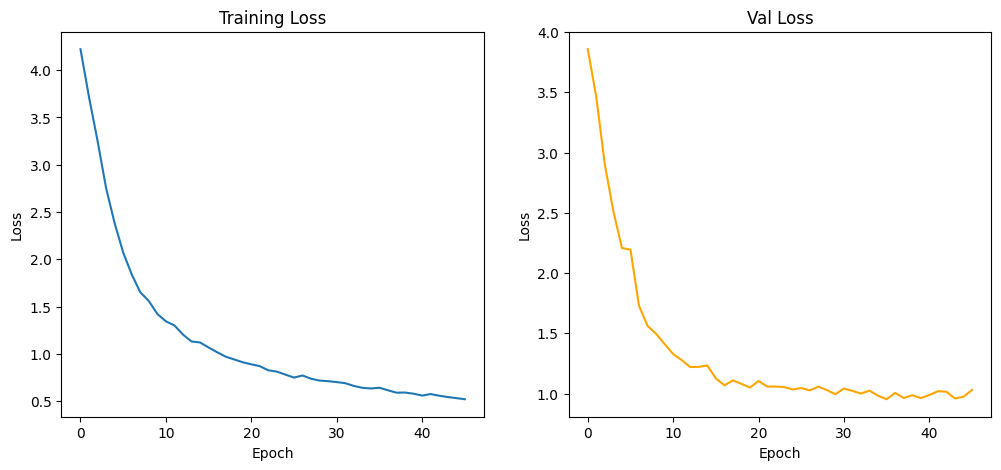

In [177]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title("Training Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[1].plot(val_losses, color="orange")
ax[1].set_title("Val Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
plt.show()

In [178]:
val_loss = evaluate(model, val_loader, criterion, device)
test_loss = evaluate(model, test_loader, criterion, device)

print("Evaluation on val/test dataset")
print("Val loss: ", val_loss)
print("Test loss: ", test_loss)

Evaluation on val/test dataset
Val loss:  1.0305463917115156
Test loss:  0.985124119122823


In [179]:
def predict(model, img):
    model.eval()
    with torch.no_grad():
        outputs = model(img)
        print(outputs)
        
def decode_label(encoded_sequences, idx_to_char, blank_char="-"):
    decoded_sequences = []

    for seq in encoded_sequences:
        decoded_label = []
        for idx, token in enumerate(seq):
            if token != 0:
                char = idx_to_char[token.item()]
                if char != blank_char:
                    decoded_label.append(char)

        decoded_sequences.append("".join(decoded_label))

    return decoded_sequences

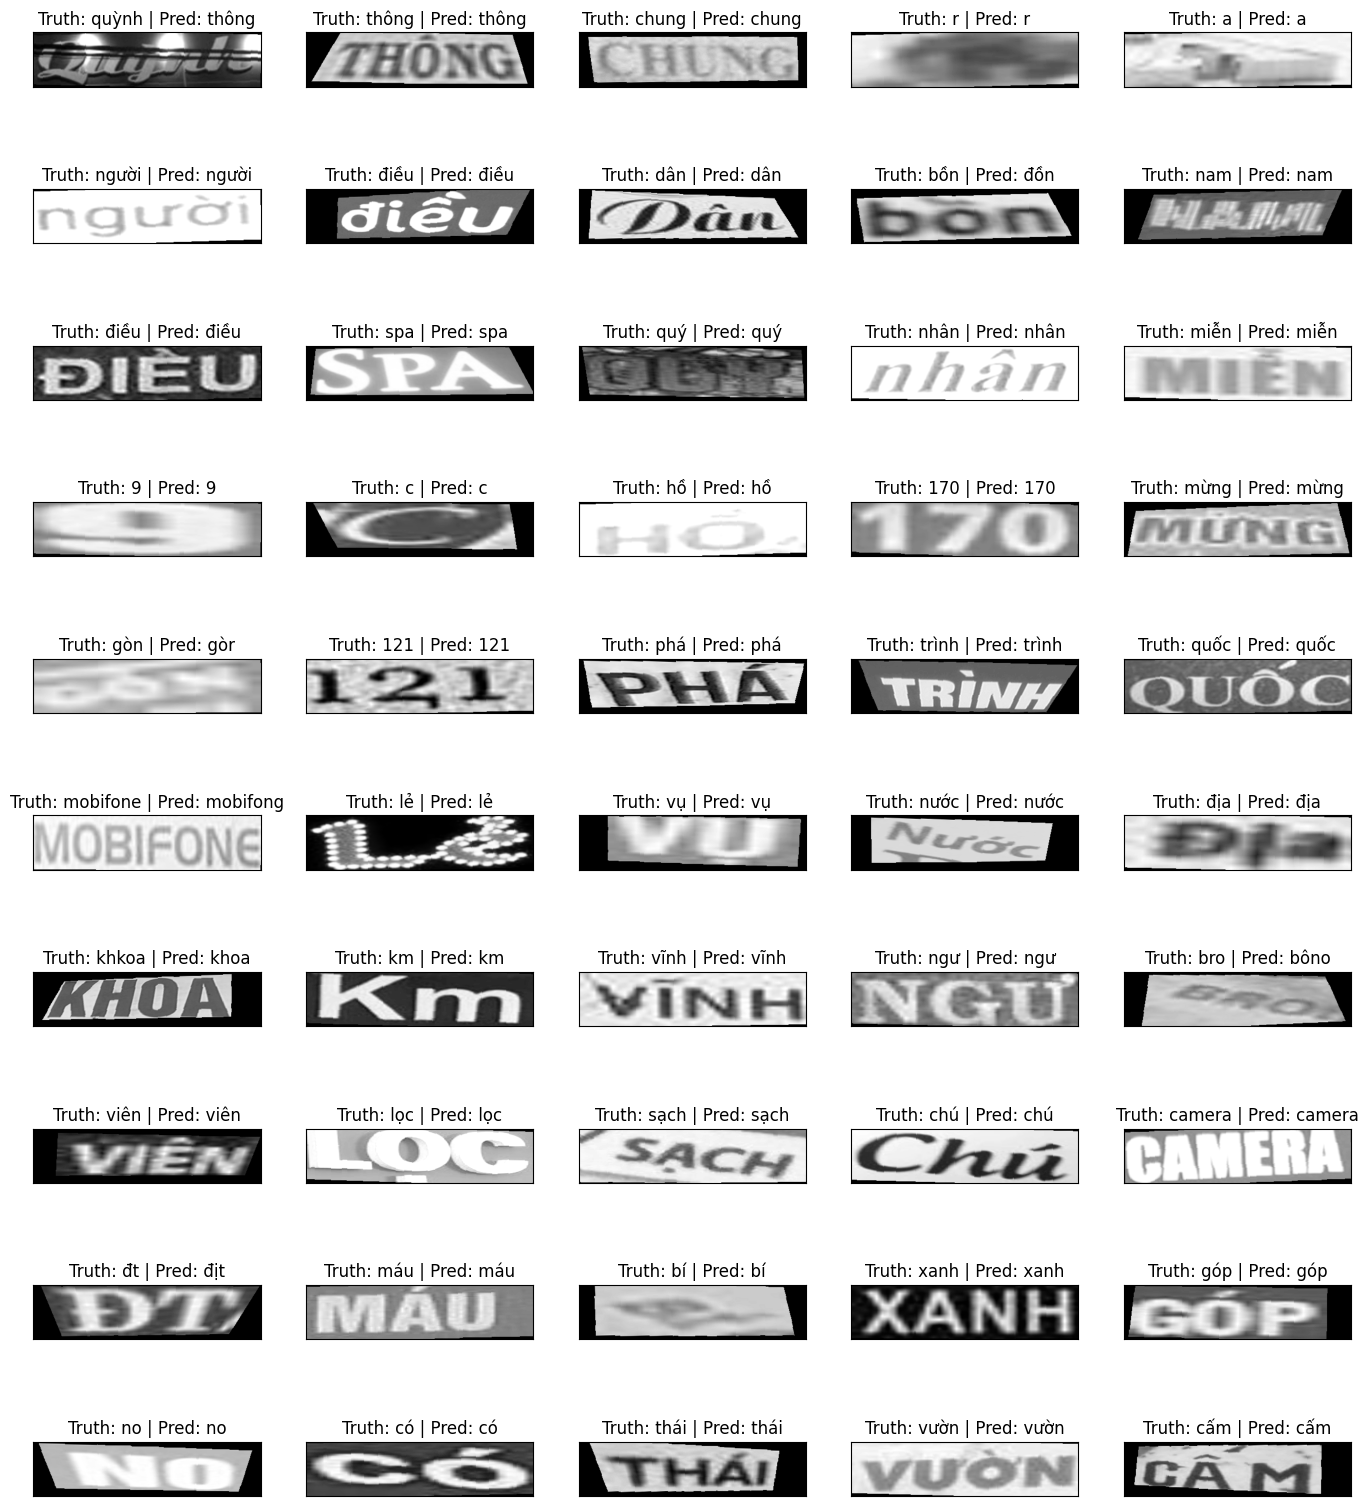

In [180]:
# view samples
sample_result = []

for i in range(50):
    idx = np.random.randint(len(val_dataset))
    img, label, label_len = train_dataset[idx]
    img = img.to(device)
    label = label.to(device)
    label = decode_label([label], idx_to_char)[0]
    logits = model(img.unsqueeze(0))

    pred_text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)[0]

    sample_result.append((img, label, pred_text))

fig = plt.figure(figsize=(17, 20))
for i in range(50):
    ax = fig.add_subplot(10, 5, i + 1, xticks=[], yticks=[])

    img, label, pred_text = sample_result[i]
    img = img.cpu()
    title = f"Truth: {label} | Pred: {pred_text}"

    ax.imshow(img.permute(1, 2, 0), cmap="gray")
    ax.set_title(title)


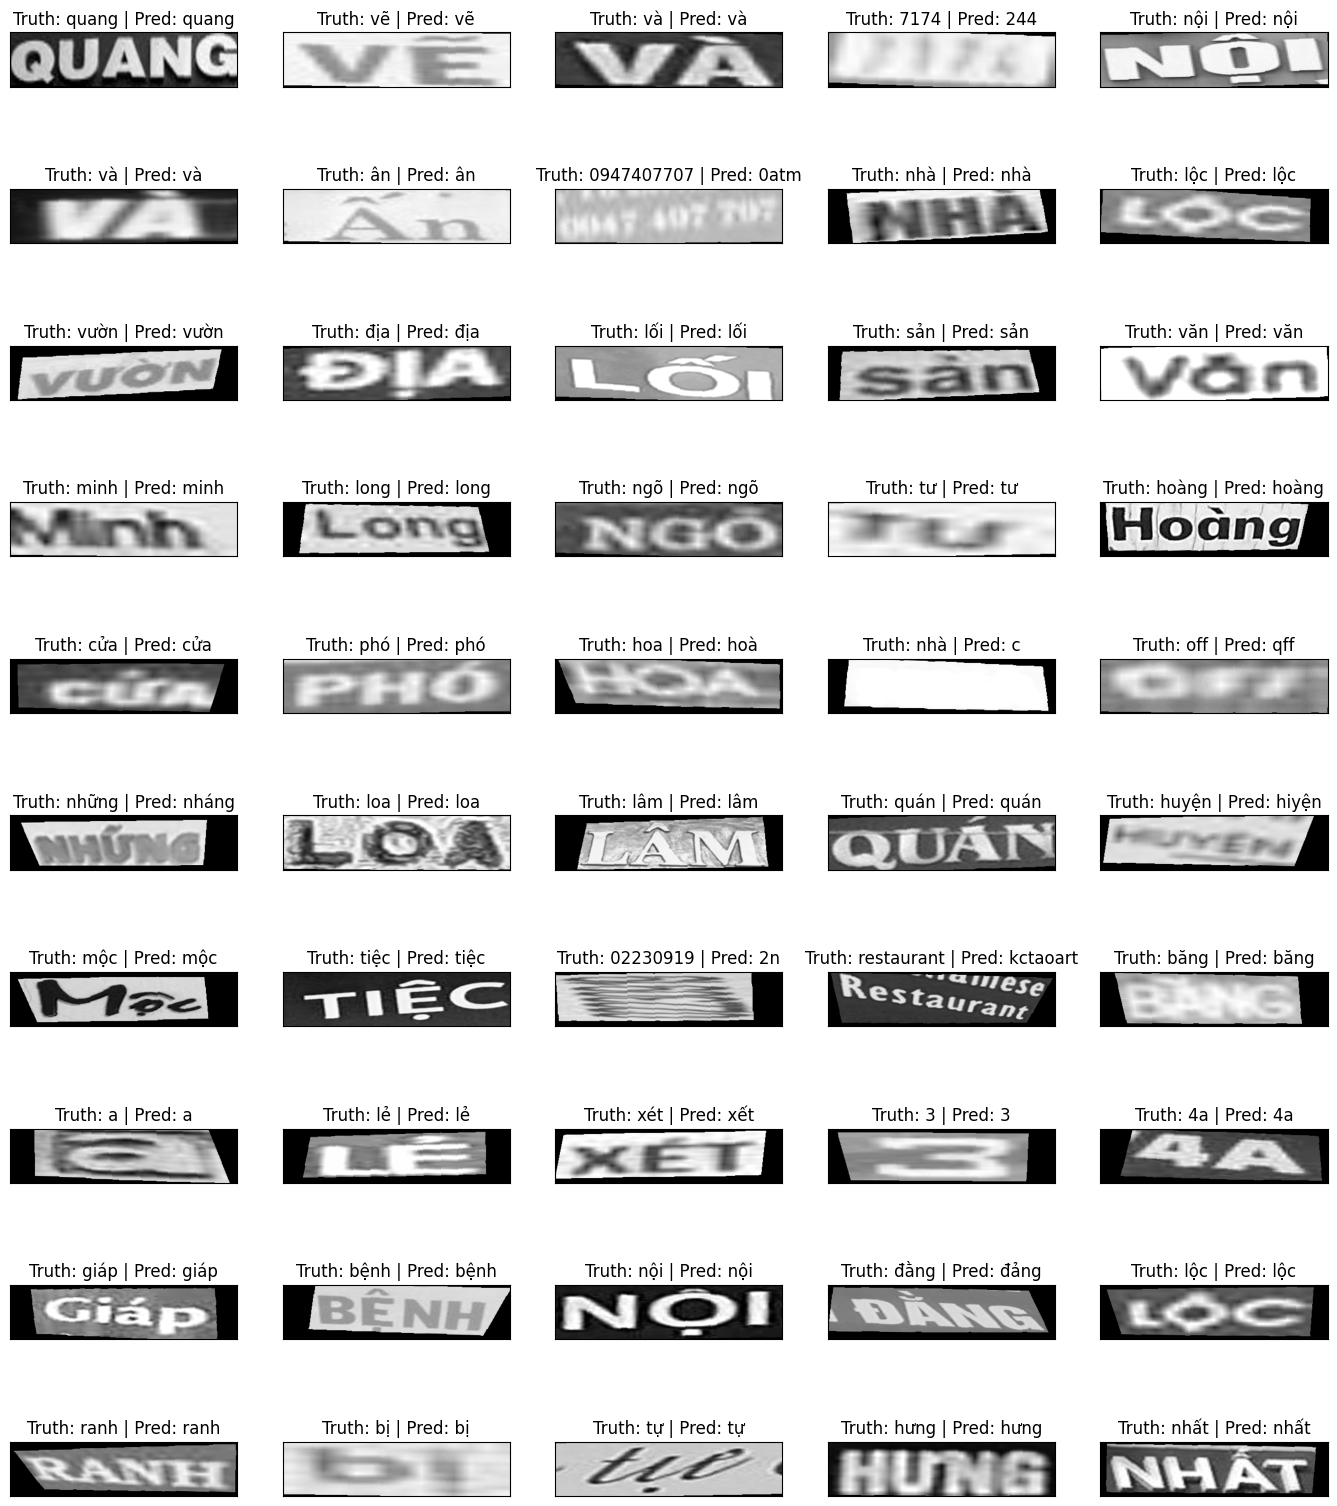

In [181]:
# view samples
sample_result = []

for i in range(50):
    idx = np.random.randint(len(test_dataset))
    img, label, label_len = train_dataset[idx]
    img = img.to(device)
    label = label.to(device)
    label = decode_label([label], idx_to_char)[0]
    logits = model(img.unsqueeze(0))

    pred_text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)[0]

    sample_result.append((img, label, pred_text))

fig = plt.figure(figsize=(17, 20))
for i in range(50):
    ax = fig.add_subplot(10, 5, i + 1, xticks=[], yticks=[])

    img, label, pred_text = sample_result[i]
    img = img.cpu()
    title = f"Truth: {label} | Pred: {pred_text}"

    ax.imshow(img.permute(1, 2, 0), cmap="gray")
    ax.set_title(title)

plt.show()

In [182]:
save_model_path = "ocr_crnn_vn.pt"
torch.save(model.state_dict(), save_model_path)

In [1]:
CHARS = "0123456789_abcdefghijklmnopqrstuvwxyzàáâãèéêìíòóôõùúýăđĩũơưạảấầẩẫậắằẳẵặẹẻẽếềểễệỉịọỏốồổỗộớờởỡợụủứừửữựỳỷỹ-"
print(f"CHARS length: {len(CHARS)}")  # Kết quả kỳ vọng: 105


CHARS length: 104


In [2]:
unique_chars = set(CHARS)
print(f"Số ký tự duy nhất: {len(unique_chars)}")
print(f"Tổng chiều dài CHARS: {len(CHARS)}")
print(f"Các ký tự bị lặp: {set([c for c in CHARS if CHARS.count(c) > 1])}")

Số ký tự duy nhất: 104
Tổng chiều dài CHARS: 104
Các ký tự bị lặp: set()


In [6]:
old_chars = sorted([...])  # Tập ký tự khi bạn train
new_chars = sorted(set(CHARS))

print("Missing from new:", set(old_chars) - set(new_chars))
print("Extra in new:", set(new_chars) - set(old_chars))
print("Số ký tự cũ:", len(old_chars))
print("Số ký tự mới:", len(new_chars))

Missing from new: {Ellipsis}
Extra in new: {'9', 'x', 'ề', 'ẽ', '3', 'ù', 'ỳ', 'ố', 'ạ', 'ệ', '8', 'ự', 'p', 'â', 'g', 'ý', 't', 'ì', 'ò', 'ữ', 'f', 'ẫ', 'r', 'ổ', 'm', 'ỏ', 'ặ', 'ầ', 'ồ', 'ậ', 'ụ', '1', 'o', 'ừ', 'đ', 'é', 'c', 'ó', '_', 'ờ', 'b', '7', 'q', 'y', 'ẩ', 'ú', 'ả', 'ắ', 'ợ', 'ẹ', 'ứ', 'ỷ', 'ỹ', '5', '-', 'ô', '2', 'ẻ', 'k', 'n', 'ỉ', 'w', 'v', 'ớ', 'ị', 'ọ', 'è', 'ỗ', 'l', 'ử', 'í', '4', 'j', 'ũ', 'h', 'ấ', 'ế', 'ê', 'ể', 'z', 'i', 'ă', 'õ', '6', 'ã', 'á', 'ễ', 'ỡ', 'ĩ', 'à', 'ở', 'a', 'd', 'ằ', 's', '0', 'ẵ', 'ơ', 'u', 'e', 'ư', 'ẳ', 'ủ', 'ộ'}
Số ký tự cũ: 1
Số ký tự mới: 104
